# Laddning av data

In [108]:
import gc # för garbage collection / frigöra minne
from external_functions import *
import joblib # för att spara tfidf vectorizer modell
import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("dark_background") #plt.style.available
gc.collect()

0

In [2]:
data = ndarray_from_file(file_path = os.path.join("data","part-01.csv"))

In [3]:
print(np.array([math.ceil(element/2) for element in [1,2,3,4,5,6,7,8,9,10]]))
data[:,0] = np.array([math.ceil(int(element)/2) for element in data[:,0]]) # Vi minskar från 10 till 5 klasser

[1 1 2 2 3 3 4 4 5 5]


In [4]:
"""Här delar vi datan i tre delar:
    En "mindre" (obalanserad) del med 10000 element
    En större (obalanserad) del med 100000 element (används ej)
    En balanserad träningsdel som skapas utifrån resterande element
"""
np.random.shuffle(data)

size1 = 10000
size2 = 100000
test = data[:size1, :]
# test_large = data[size1:size1 + size2, :]
train_unbalanced = data[size1 + size2:, :]

print(np.bincount(train_unbalanced[:, 0].astype(int))) # Utskrift över antalet element per klass (av någon anledning blir det en extra klass i början)
min_val = min(np.bincount(train_unbalanced[:, 0].astype(int))[1:])
print(f"Minimum value: {min_val}")

num_classes = len(np.bincount(train_unbalanced[:, 0].astype(int))) - 1
train = []
for i in range(1, num_classes+1):
    train.append(data[data[:, 0] == i][:min_val])
train = np.vstack(train)
np.random.shuffle(train)
assert len(train) == num_classes * min_val

print(train.shape)

[     0  85861  61842  97366 158917 197250]
Minimum value: 61842
(309210, 2)


In [5]:
# Dessa rader kod är bortkommenterade för att spara minne. Kör dem istället för de nedan för att testa Naiv Bayes på obalanserad data
# y_train_unbalanced = train_unbalanced[:,0]
# x_train_unbalanced = train_unbalanced[:,1]
# y_train_unbalanced = y_train_unbalanced.astype(int)
# y_test_large = test_large[:,0]
# x_test_large = test_large[:,1]
# y_test_large = y_test_large.astype(int)


y_test = test[:,0]
x_test = test[:,1]
y_test = y_test.astype(int)
y_train = train[:,0]
x_train = train[:,1]
y_train = y_train.astype(int)

# Naiv Bayes

In [6]:
# Dessa rader kod är bortkommenterade för att spara minne. Kör dem istället för de nedan för att testa Naiv Bayes på obalanserad data
# vectorizer_unbalanced = TfidfVectorizer(max_features = 10000)
# x_train_trans_unbalanced = vectorizer_unbalanced.fit_transform(x_train_unbalanced)
# x_test_trans_unbalanced = vectorizer_unbalanced.transform(x_test)

vectorizer = TfidfVectorizer(max_features = 10000)
x_train_trans = vectorizer.fit_transform(x_train)
x_test_trans = vectorizer.transform(x_test)
x_train_trans.shape

(309210, 10000)

In [101]:
x_train_trans[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# Kommentera ut för att spara vecotrizern i en sparat fil. Behövs om vill kunna ladda modellen för det neurala nätverket från en separat fil
# eftersom modellen måste köras med data från exakt samma vectorizer (vectorizern skiljer sig eftersom vi kallar på np.random.shuffle())
# joblib.dump(vectorizer_balanced, 'tfidf_vectorizer.joblib') 

['tfidf_vectorizer.joblib']

              precision    recall  f1-score   support

           1      0.552     0.692     0.614      1476
           2      0.295     0.400     0.340       996
           3      0.406     0.383     0.394      1635
           4      0.513     0.431     0.468      2604
           5      0.704     0.658     0.680      3289

    accuracy                          0.533     10000
   macro avg      0.494     0.513     0.499     10000
weighted avg      0.542     0.533     0.535     10000



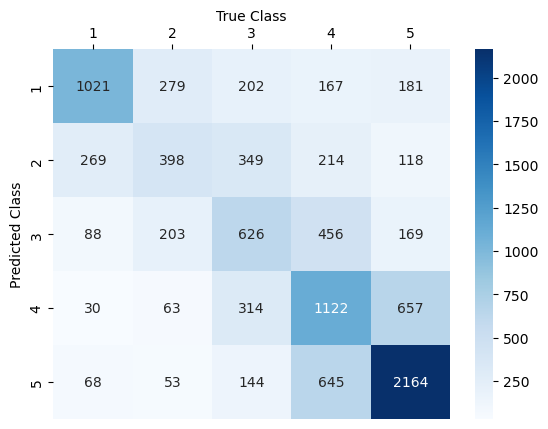

In [7]:
clf = MultinomialNB().fit(x_train_trans, y_train)
y_pred = clf.predict(x_test_trans)
print(classification_report(y_test, y_pred, digits=3))
print_confusion_matrix(y_true=y_test, y_pred=y_pred, num_classes=5)

              precision    recall  f1-score   support

           1      0.580     0.585     0.583      1416
           2      0.319     0.023     0.044       984
           3      0.390     0.111     0.173      1655
           4      0.407     0.514     0.454      2679
           5      0.558     0.794     0.656      3266

    accuracy                          0.500     10000
   macro avg      0.451     0.406     0.382     10000
weighted avg      0.469     0.500     0.451     10000



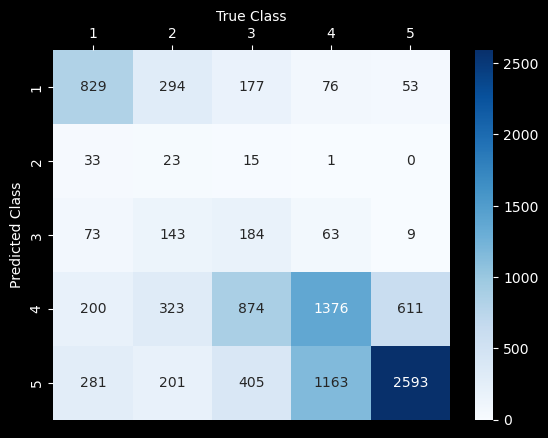

In [34]:
# Kommentera bort för att köra på obalanserad data
# clf_balanced = MultinomialNB().fit(x_train_trans_unbalanced, y_train_unbalanced)
# y_pred = clf_balanced.predict(x_test_trans_unbalanced)
# print(classification_report(y_test, y_pred, digits=3))
# print_confusion_matrix(y_true=y_test, y_pred=y_pred, num_classes=5)

In [59]:
def create_indicies(probs, words, max_features):
    word_dict = {}
    max_features = 1000
    for n in range(len(words)):
        word = words[n]
        prob = probs[:,n]
        word_dict[(word, n)] = max(prob) - min(prob)
    word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True)) # Sortering i fallande storleksordning
    indicies = [x[1] for x in list(word_dict.keys())[:max_features]]
    assert len(indicies) == 1000
    return word_dict, indicies

word_dict, indicies = create_indicies(probs=clf.feature_log_prob_, words=vectorizer.get_feature_names_out(), max_features=1000)
# word_dict_unbalanced, indicies_unbalanced = create_indicies(probs=clf_balanced.feature_log_prob_, words=vectorizer_balanced.get_feature_names_out(), max_features=2000)
print(word_dict) # Avnänds ej. Syftar enbart till att ge förståelse
print(indicies)

{('bangladesh', 698): 4.025491131815889, ('harshad', 4055): 3.6340375794854793, ('armenian', 470): 3.6001791097893463, ('huis', 4325): 3.5069257253789736, ('bangladeshis', 700): 3.4357277156454398, ('unfunny', 9386): 3.3820525943387665, ('bangladeshi', 699): 3.3391523713902256, ('anubis', 389): 3.2824380199428926, ('hindus', 4194): 3.2455351815988163, ('dhawan', 2422): 3.2035192301665862, ('het', 4164): 3.200255349883431, ('waste', 9718): 3.1612288022583748, ('steaming', 8517): 3.1450364875752577, ('laughable', 5106): 3.125291336402161, ('tripe', 9222): 3.1208013337344305, ('garbage', 3660): 3.1157858083771144, ('atrocious', 559): 3.1138318933518807, ('pleasantly', 6747): 3.094017162734147, ('turd', 9265): 3.0850032516367722, ('mehta', 5643): 3.070228315941307, ('sushant', 8766): 3.043370693697259, ('redeeming', 7286): 3.041428450023737, ('thumbsdown', 9030): 3.02747622138409, ('hindu', 4193): 3.0258804794375393, ('govinda', 3834): 3.0188788721459066, ('uninteresting', 9401): 3.0167352

In [40]:
# Exempelkod för att hitta de viktigaste orden. Viktigt att inte indicies.sort() körts innan
probs=clf.feature_log_prob_
words=vectorizer.get_feature_names_out()
for n in range(len(words)):
    word = words[n]
    prob = probs[:,n]
    if abs(prob[0] - prob[4]) > 3:
        # if max(prob[1:4]) - min(prob) > 2.2:
            print(word, prob)

bangladeshis [ -9.4751369  -12.80344738 -12.96304956 -12.96856113 -12.6502324 ]
dhawan [ -8.89702015 -11.16422964 -11.20484627 -11.71535635 -12.04934684]
drivel [ -8.30576874  -9.2629246  -10.5579681  -10.91053144 -11.60317511]
harshad [-12.82102892 -12.65185909 -12.78589862 -12.07848726  -9.10872471]
mehta [-12.45985507 -11.71801679 -11.22993976 -10.89211137  -8.91568033]
steaming [ -9.09379601 -10.49606674 -11.81880865 -12.23874196 -12.65332444]
stinker [ -8.92180863  -9.56350485 -10.8073209  -11.12730384 -11.94110055]
unfunny [ -7.97075404  -8.47807747  -9.5415063  -10.93516795 -11.18711024]
unwatchable [ -8.0065671   -8.83721627  -9.73947612 -10.78200768 -11.17194776]
varun [ -8.53254085 -10.88607067 -11.17415438 -11.70748032 -11.57314056]
waste [-5.63992761 -6.51534342 -7.53351624 -8.63503512 -8.87122011]


In [169]:
# Bortkommentera för att spara indexen för de viktigaste orden. Behövs om vill kunna ladda modellen för det neurala nätverket från en separat fil
# eftersom modellen måste köras med data från exakt samma vectorizer som har slicats med exakt som index
# indicies.sort() # Gör slicing snabbare (används för neuralt nätverk)
# with open('indicies.txt', 'w') as file:
#     for item in indicies:
#         file.write(f"{item}\n")

In [106]:
# Ger "sannolikhetsvektorn" för valt ord
print(clf.feature_log_prob_[:,np.where(vectorizer.get_feature_names_out() == "surprised")[0][0]])

[-8.22537135 -8.24591429 -8.16948757 -7.69404721 -7.78320231]


# Neural Network

In [11]:
def custom_activation(x):
    # return 5 * tf.keras.activations.sigmoid(x) + 0.5
    return 5*tf.minimum(tf.nn.relu(x), 1) + 0.5

In [12]:
def accuracy(y_true, y_pred):
    """Beräknar accuracy med outputen avrundad till närmaste heltal"""
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(y_pred), y_true), tf.float32))

In [15]:
x_train_small = x_train_trans.toarray()[:,indicies]
x_test_small = x_test_trans.toarray()[:,indicies]
x_train_small.shape

(309210, 1000)

Epoch 1/200
310/310 [==============================] - 80s 253ms/step - loss: 1.2133 - accuracy: 0.3569 - val_loss: 1.0342 - val_accuracy: 0.4051
Epoch 2/200
310/310 [==============================] - 88s 285ms/step - loss: 1.0375 - accuracy: 0.3905 - val_loss: 1.1011 - val_accuracy: 0.3410
Epoch 3/200
310/310 [==============================] - 85s 275ms/step - loss: 1.0133 - accuracy: 0.4005 - val_loss: 1.0708 - val_accuracy: 0.3668
Epoch 4/200
310/310 [==============================] - 86s 278ms/step - loss: 0.9698 - accuracy: 0.4168 - val_loss: 0.9031 - val_accuracy: 0.4675
Epoch 5/200
310/310 [==============================] - 88s 284ms/step - loss: 0.9135 - accuracy: 0.4428 - val_loss: 0.8272 - val_accuracy: 0.4922
Epoch 6/200
310/310 [==============================] - 87s 280ms/step - loss: 0.8484 - accuracy: 0.4728 - val_loss: 0.8068 - val_accuracy: 0.4876
Epoch 7/200
310/310 [==============================] - 88s 284ms/step - loss: 0.7959 - accuracy: 0.4972 - val_loss: 0.8872 -

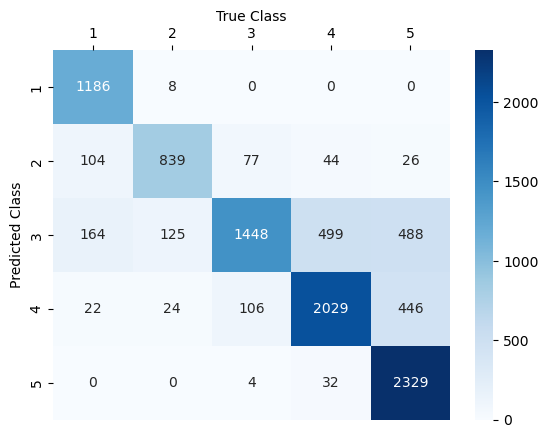

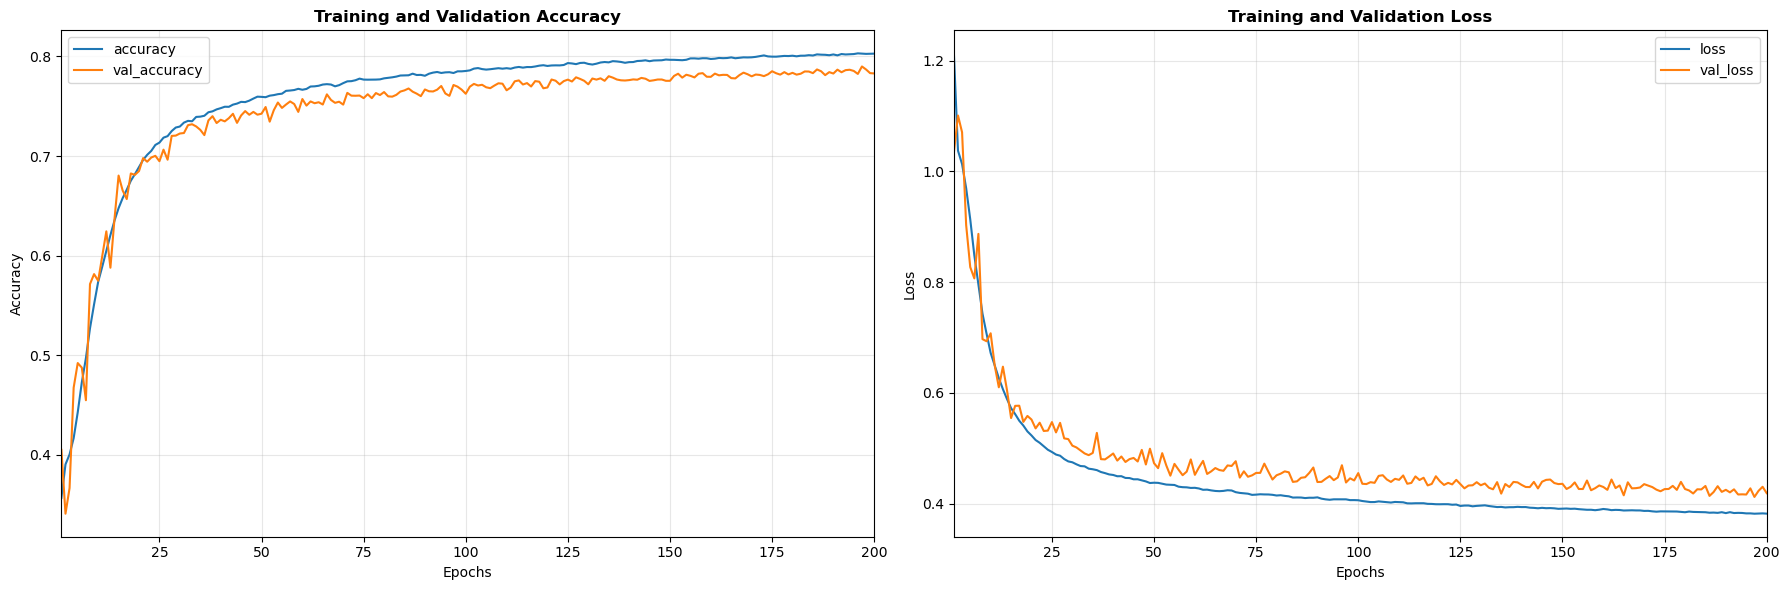

In [22]:
# Resultat från körning med inputvekotrer motsvarande 2500 viktigaste orden
model = tf.keras.Sequential([
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu', input_dim=x_train_small.shape[1]),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(1, activation=custom_activation)
])
model.compile(loss='mse', optimizer='adam', metrics=[accuracy])
history = model.fit(x_train_small, y_train, epochs=200, batch_size=1000, validation_data=(x_test_small, y_test))
result = model.predict(x_test_small)
y_pred = np.array([custom_round(x) for x in result[:,0]])
print(f"Antal korrekta klassificeringar: {np.sum(y_pred == y_test)}")
print(classification_report(y_test, y_pred, digits=3))
print_confusion_matrix(y_true=y_test, y_pred=y_pred, num_classes=5)
plot_results(history.history, ["accuracy", "loss"])

Epoch 1/200
310/310 [==============================] - 78s 249ms/step - loss: 1.1851 - accuracy: 0.3585 - val_loss: 1.0857 - val_accuracy: 0.3769
Epoch 2/200
310/310 [==============================] - 86s 277ms/step - loss: 1.0379 - accuracy: 0.3891 - val_loss: 1.0284 - val_accuracy: 0.3910
Epoch 3/200
310/310 [==============================] - 87s 281ms/step - loss: 1.0132 - accuracy: 0.3998 - val_loss: 0.9844 - val_accuracy: 0.4025
Epoch 4/200
310/310 [==============================] - 90s 289ms/step - loss: 0.9744 - accuracy: 0.4136 - val_loss: 0.8994 - val_accuracy: 0.4476
Epoch 5/200
310/310 [==============================] - 90s 291ms/step - loss: 0.9192 - accuracy: 0.4363 - val_loss: 0.9214 - val_accuracy: 0.4331
Epoch 6/200
310/310 [==============================] - 89s 286ms/step - loss: 0.8524 - accuracy: 0.4661 - val_loss: 0.7894 - val_accuracy: 0.4912
Epoch 7/200
310/310 [==============================] - 92s 295ms/step - loss: 0.7953 - accuracy: 0.4966 - val_loss: 0.7183 -

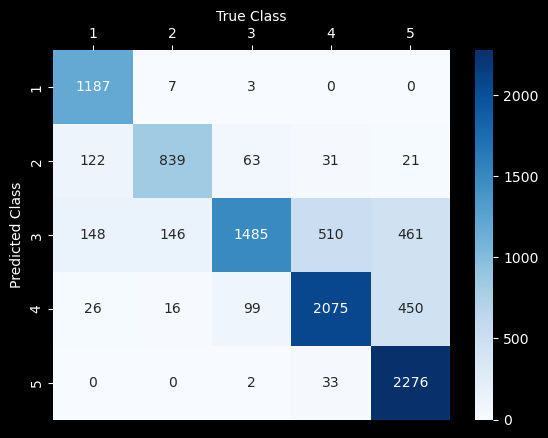

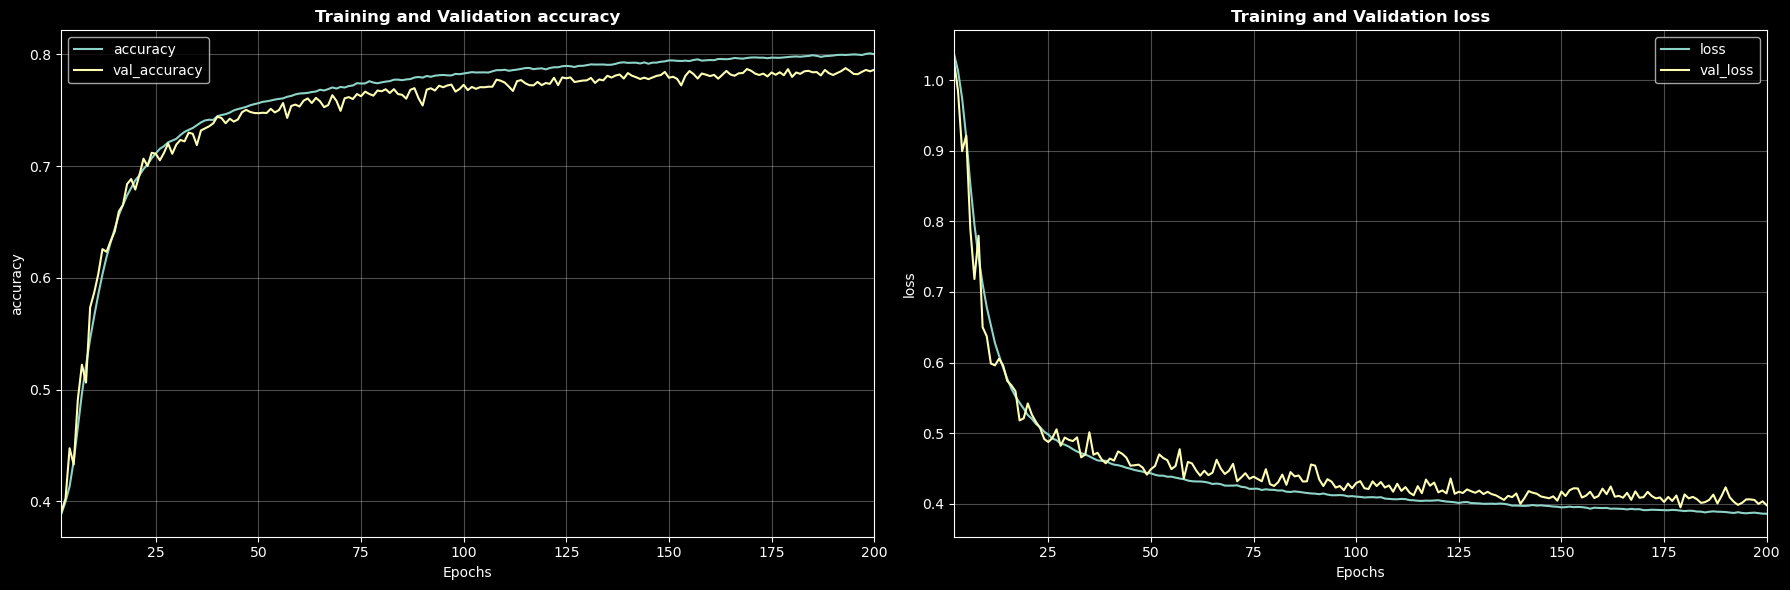

In [50]:
# Resultat från körning med inputvektorer motsvarande 1000 viktigaste orden
model = tf.keras.Sequential([
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu', input_dim=x_train_small.shape[1]),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(x_train_small.shape[1], activation='relu'),
    tf.keras.layers.Dense(1, activation=custom_activation)
])
model.compile(loss='mse', optimizer='adam', metrics=[accuracy])
history = model.fit(x_train_small, y_train, epochs=200, batch_size=1000, validation_data=(x_test_small, y_test))
result = model.predict(x_test_small)
y_pred = np.array([custom_round(x) for x in result[:,0]])
print(f"Antal korrekta klassificeringar: {np.sum(y_pred == y_test)}")
print(classification_report(y_test, y_pred, digits=3))
print_confusion_matrix(y_true=y_test, y_pred=y_pred, num_classes=5)
plot_results(history.history, ["accuracy", "loss"])

In [51]:
# Spara modell och träningsresultat
# model.save("my_model.keras")
# dict_to_csv(history.history, "model_output.csv") # Sparar figurdatan till csv-fil

In [ ]:
# Som alternativ till koden ovan kan följande kod köras om erforderliga filer skapats. Därefter kan man direkt anropa funktionen make_prediction
vectorizer = joblib.load("tfidf_vectorizer.joblib")
model = tf.keras.models.load_model("my_model.keras", custom_objects={"custom_activation": custom_activation, "accuracy": accuracy})
with open("indicies.txt", "r") as file:
    indicies = [int(line.strip()) for line in file]

In [110]:
review = "I hated this movie. It was awful and I would even say it's unwatchable! I'm very disappointed and glad I'll never have to see it again"
make_prediction(model, vectorizer, indicies, review)

1/1 [==============================] - 0s 108ms/step
1
